In [3]:
Ns=4 #only even numbers
N, PBC = 3, False
J, U,V = 1,40,-1.97
Nf =20

In [4]:
from numpy import zeros, sqrt, linalg, array, ones, exp, eye, copy,sign,real,imag,transpose,log,average,sort, var, conj, math, var,append, save,argsort
import matplotlib.pyplot as plt
from random import randint
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time

def genBase(js_,N_,base_,baseQ1_):
    if N_==0:
        base_.append( [0]*Ns )
        for j in js_:
            base_[-1][j]+=1
        baseQ1_.append(list([x for x in js_]))
       # print(baseQ1_[-1])
    else:
        leftBound = 0
        if len(js_)>0:
            leftBound = js_[-1]
        for j in range(leftBound,Ns):
            genBase(js_+[j],N_-1,base_,baseQ1_)
        
base, baseQ1 = [], []
base1, base1Q1 = [],[]
base2, base2Q1= [],[]

genBase([],1,base1,base1Q1)
genBase([],2,base2,base2Q1)
genBase([],N,base,baseQ1)

NoS1, NoS2, NoS = len(base1), len(base2), len(base)

print('Number of base states =',NoS)

Number of base states = 20


In [5]:
#################################################################
##Compute energy and the GS of H for choosen N ##################
#################################################################

def generateHamitlonian(base_, J_,U_,V_):
    NoS = len(base_)
    H = lil_matrix((NoS,NoS),dtype=float)
    for i in range(NoS):
        sL = base_[i]

        for j in range(0,Ns-1):
            if sL[j]>0:
                coef = -J_*sqrt(sL[j])*sqrt(sL[j+1]+1)
                sR = [x for x in sL]
                sR[j]-=1
                sR[j+1]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        if PBC:     
            if sL[Ns-1]>0:
                coef = -J_*sqrt(sL[Ns-1])*sqrt(sL[0]+1)
                sR = [x for x in sL]
                sR[Ns-1]-=1
                sR[0]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef

        coefU = 0.0
        for j in range(0,Ns):
            coefU += 0.5*U_*sL[j]*(sL[j]-1)
        H[i,i] += coefU

        coefV = 0.0
        for j in range(0,Ns-1):
            coefV += V_*sL[j]*sL[j+1]
        if PBC:  
            coefV += V_*sL[Ns-1]*sL[0]
        H[i,i] += coefV
    return H

print("Computing reference GS...",end='')
t0 = time.time()

H_1atom = generateHamitlonian(base1, J,U,V)
E, v = eigsh(H_1atom,k=1,which='SA')  
E_1atom = E[0]
GS_1atom = sign(v[0,0])*v[:,0]

H_2atom = generateHamitlonian(base2, J,U,V)
E, v = eigsh(H_2atom,k=1,which='SA')  
E_2atom = E[0]
GS_2atom = sign(v[0,0])*v[:,0]

H = generateHamitlonian(base, J,U,V)
E, v = eigsh(H,k=1,which='SA')  
E_R = E[0]
GS = sign(v[0,0])*v[:,0]
print(" DONE in ",(time.time()-t0)*1000,"[ms]")

Computing reference GS... DONE in  3.635883331298828 [ms]


In [6]:
def secondToFirst(state):
    baseState = state.copy()
    js = [0]*N
    for i in range(N):
        for n in range(Ns):
            if baseState[n]>0:
                js[i]=n
                baseState[n]-=1
                break
    return js

def norm(fock):
    out = math.factorial(N)
    for n in range(Ns):
        out /= math.factorial(fock[n])
    return sqrt(out)

def energy(c):
    return sum(real(conj(c)*H*c))

def getNis(c):
    out = zeros(Ns)
    for i in range(NoS):
        out += abs(c[i])**2*array(base[i])
    return out   

def getG2sX(c,x):
    G2s = zeros(Ns,dtype=complex)
    for i in range(NoS):
        fock = base[i]
        for xp in range(Ns):
            G2s[xp] += abs(c[i])**2*fock[x]*fock[xp]
            if x==xp:
                G2s[xp] -= abs(c[i])**2*fock[x]
    return G2s  

print("Only functions")

Only functions


In [8]:
#print(len(baseQ1),len(base))
#print(baseQ1)
        
#########################333####################################################################
combs, combsh = [], []

for n in range(Ns):
    for n2 in range(n, Ns):
        combs.append([n,n2])
        if n+n2 < Ns:
            combsh.append([n,n2])

baseMask = list(argsort(-abs(GS))[-Nf:])
frac = 0.0
# for i in range(NoS):
#     frac+= abs(GS[i])**2
    
for m in baseMask:
    print(GS[m])
    frac+= abs(GS[m])**2
print("Frac=",frac)
# for comb in combs:
#     js = [j for j in baseQ1[baseMask[0]]]
#     js[0]=comb[0]
#     js[1]=comb[1]
#     js = sort(list(js))
#     ind = baseQ1.index(list(js))
#     if not ind in baseMask:
#         baseMask.append( ind )
        
#     js = [j for j in baseQ1[baseMask[4]]]
#     js[0]=comb[0]
#     js[1]=comb[1]
#     js = sort(list(js))
#     ind = baseQ1.index(list(js))
#     if not ind in baseMask:
#         baseMask.append( ind )
        
#     js = [j for j in baseQ1[baseMask[11]]]
#     js[0]=comb[0]
#     js[1]=comb[1]
#     js = sort(list(js))
#     ind = baseQ1.index(list(js))
#     if not ind in baseMask:
#         baseMask.append( ind )
        
# Nf = len(baseMask)
# baseMask = list(argsort(-abs(GS))[-Nf:])
# print(Nf)

def P(fockState):
    js = secondToFirst(fockState)
    out = zeros(int(Ns*(Ns+1)/2),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            out[combs.index([js[n],js[np]])]+=1
    return out

def Ph(fockState):
    js = secondToFirst(fockState)
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)    
            out[combsh.index([ind1,ind2])]+=1
    return out

A1 = zeros([Nf,int((Ns+1)/2)],dtype=int)

for i in range(Nf):
    A1[i] = array(base[baseMask[i]][0:int((Ns+1)/2)])  + array(base[baseMask[i]][Ns:int((Ns-1)/2):-1])
    
A2 = zeros([Nf,len(combs)],dtype=int)
A2h = zeros([Nf,len(combsh)],dtype=int)
B = zeros(Nf,dtype=float)
    
for i in range(Nf):
    A2[i] = P(base[baseMask[i]])
    A2h[i] = Ph(base[baseMask[i]])
    B[i] = GS[baseMask[i]]
    
def psi12to14(psi12):
    out = []
    num =0
    for comb in combs:
        if comb[0]+comb[1]< Ns:
            out.append(psi12[num])
        num+=1
    return array(out)

def psi14to12(psi14):
    out = zeros(len(combs))
    num =0
    for combh in combsh:
        ind1 = combh[0]
        ind2 = combh[1]
        out[combs.index([ind1,ind2])] = psi14[num]
        
        ind1 += Ns-1-(combh[0]+combh[1])
        ind2 += Ns-1-(combh[0]+combh[1])
        out[combs.index([ind1,ind2])] = psi14[num]
        num+=1      
    return out
     
##############################################################################################

Norms_2atom = []
for i in range(len(base2)):
    Norms_2atom.append( norm(base2[i]) )

Norms1f = zeros(Nf,dtype=float)
for i in range(Nf):
    Norms1f[i]= norm(base[baseMask[i]])
    
Norms1 = []
for i in range(NoS):
    Norms1.append( norm(base[i]) )

def variance1h( psi ):
    c = normalised(real(array(Norms1f)*exp(A1.dot(log(psi,dtype=complex)))))
    return sum((c-B)**2)

def findPsi1(method='half'):
    print("Looking for Psi_A1...",end='')
    minimizer_kwargs = {"method": "COBYLA"}
    t0 = time.time()
    if method=='half':
        psi0h = GS_1atom[0:int((Ns+1)/2)]
        reth = basinhopping(variance1h, psi0h, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=10)
        psi = append(reth.x, reth.x[::-1])
    if method=='whole':
        psi0 = GS_1atom
        ret = basinhopping(variance1, psi0, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=5)
        psi = ret.x
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi

0.6018768854873625
0.6018768854873181
0.3678282450291045
0.3678282450291044
0.03113793683264471
0.031137936832643407
0.022748328120414857
0.02274832812041326
0.020944978126464165
0.020944978126462288
0.019313978672512867
0.01931397867251128
0.012049886192972628
0.012049886192972469
0.0014997912659459576
0.0014997912659454604
0.0006065368562910289
0.0006065368562910006
2.0819634806309995e-05
2.0819634806248835e-05
Frac= 1.0


In [124]:
####################################################
## Functions for Ansatz 2 ##########################
####################################################

def normalised(arr):
    return arr / sqrt(sum(abs(arr)**2))

def variance2( psi ):
    c = Norms1f*exp(A2.dot(log(psi,dtype=float)))
    return 1-(c.dot(B)/sqrt(c.dot(c)))**2

def variance2h( psi ):
    c = Norms1f*exp(A2h.dot(log(psi,dtype=float)))
    return sum((c-B)**2)

def findPsi2h():
    print("Looking for Psi_A2...",end='')
    t0 = time.time()
    psi0 = psi12to14(GS_2atom)
    ret = minimize(variance2h, psi0, method='Powell', tol=1e-4, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi14to12(ret.x)

def reshapePhiTo2D(phi1D):
    out = zeros([Ns,Ns],dtype=complex)
    num=0
    for n in range(Ns):
        out[n][n] = phi1D[num]
        num+=1
        for n2 in range(n+1, Ns):
            out[n][n2] = phi1D[num]
            out[n2][n] = phi1D[num]
            num+=1
    return out

print("Only functions")

Only functions


In [125]:
####################################################
## Compute best Ansatz functions ###################
####################################################
psiA1 = findPsi1()
phiA21D = findPsi2h()

phiA2 = reshapePhiTo2D(phiA21D)
phiJ = reshapePhiTo2D(GS_2atom)

# c = Norms1f*exp(A2h.dot(log(psi12to14(phiA21D),dtype=float)))
# print( sum((c-B)**2) )

Looking for Psi_A1... DONE in 6502.87938117981 [ms]
Looking for Psi_A2... DONE in 1916.6109561920166 [ms]


(E_GS-E_free)/(|N E_free|) =  -0.023370151617876474
|<ED|A1>|^2 =  0.25000059981403516
|<ED|A2>|^2 =  0.25
|<ED|A2>|^2 =  0.9999999999990776
|<ED|J>|^2 =  0.2500000000000002


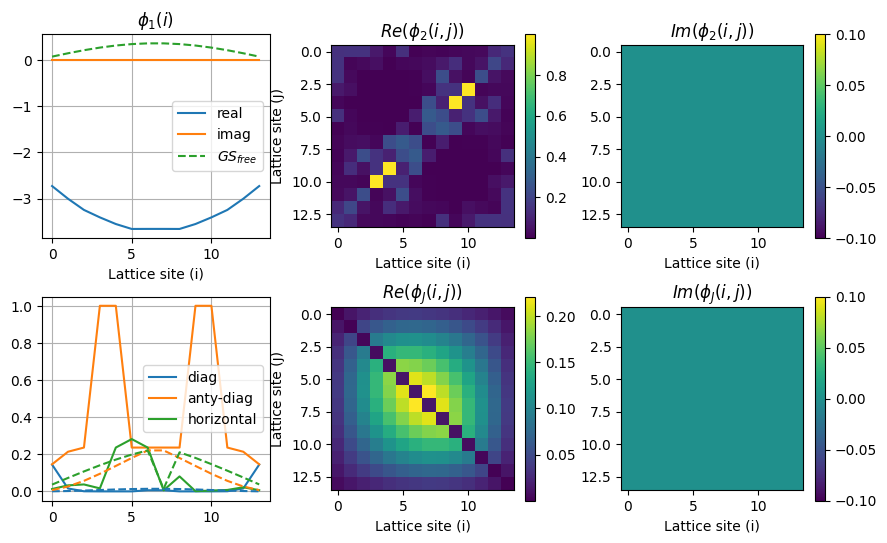

In [126]:
####################################################
## Plot Ansatz functions ###########################
####################################################

import numpy as np
# psiA1 /= sqrt(sum(abs(psiA1)**2))

# phiA21D /= sqrt(sum(sum(abs(phiA2)**2)))
# phiA2 /= sqrt(sum(sum(abs(phiA2)**2)))
# phiJ /= sqrt(sum(sum(abs(phiJ)**2)))

print('(E_GS-E_free)/(|N E_free|) = ', (E_R-N*E_1atom)/(abs(N*E_1atom)) )


print('|<ED|A1>|^2 = ',(1-0.5*variance1h(psiA1[0:int(Ns/2)]))**2)
print('|<ED|A2>|^2 = ',(1-0.5*variance2(phiA21D))**2)
print('|<ED|A2>|^2 = ',(1-0.5*variance2h(psi12to14(phiA21D)))**2)
print('|<ED|J>|^2 = ',(1-0.5*variance2(GS_2atom))**2)

fig, ax = plt.subplots(2,3,figsize=(9,5.5))
ax[0,0].plot(real(psiA1),label='real')
ax[0,0].plot(imag(psiA1),label='imag')
ax[0,0].plot(GS_1atom,'--',label = '$GS_{free}$')
cmap = ax[0,1].imshow(real(phiA2))
cbar = plt.colorbar(cmap)
cmap = ax[0,2].imshow(imag(phiA2))
cbar = plt.colorbar(cmap)
cmap = ax[1,1].imshow(real(phiJ))
cbar = plt.colorbar(cmap)
cmap = ax[1,2].imshow(imag(phiJ))
cbar = plt.colorbar(cmap)

# ax[1,0].plot([real(phiA2)[i,i] for i in range(Ns)])
# ax[1,0].plot([real(phiA2)[i,Ns-1-i] for i in range(Ns)])

ax[1,0].plot([real(phiA2)[i,i] for i in range(Ns)],label='diag')
ax[1,0].plot([real(phiA2)[i,Ns-1-i] for i in range(Ns)],label='anty-diag')
ax[1,0].plot([real(phiA2)[int(Ns/2),i] for i in range(Ns)],label='horizontal')

ax[1,0].plot([real(phiJ)[i,i] for i in range(Ns)],'--',c='tab:blue')
ax[1,0].plot([real(phiJ)[i,Ns-1-i] for i in range(Ns)],'--',c='tab:orange')
ax[1,0].plot([real(phiJ)[int(Ns/2),i] for i in range(Ns)],'--',c='tab:green')


ax[0,0].grid()
ax[1,0].grid()
ax[1,0].legend()
ax[0,0].legend()
ax[0,0].set_xlabel('Lattice site (i)')
ax[0,1].set_xlabel('Lattice site (i)')
ax[0,1].set_ylabel('Lattice site (j)')
ax[0,2].set_xlabel('Lattice site (i)')
#ax[0,2].set_ylabel('Lattice site (j)')

ax[0,0].set_title('$\phi_1(i)$')
ax[0,1].set_title('$Re(\phi_2(i,j))$')
ax[0,2].set_title('$Im(\phi_2(i,j))$')

ax[1,1].set_xlabel('Lattice site (i)')
ax[1,1].set_ylabel('Lattice site (j)')
ax[1,2].set_xlabel('Lattice site (i)')
#ax[1,2].set_ylabel('Lattice site (j)')

ax[1,1].set_title('$Re(\phi_J(i,j))$')
ax[1,2].set_title('$Im(\phi_J(i,j))$')
plt.tight_layout()
#plt.savefig("40_-1.97_N3_Ns30.func.png")
np.save(("Ns%i_N%i_J%f_U%f_V%f"%(Ns,N,J,U,V)),real(phiA2))
plt.savefig(("2_Ns%i_N%i_J%f_U%f_V%f.png"%(Ns,N,J,U,V)))
#print(real(phiA2))
plt.show()

/home/maciek/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


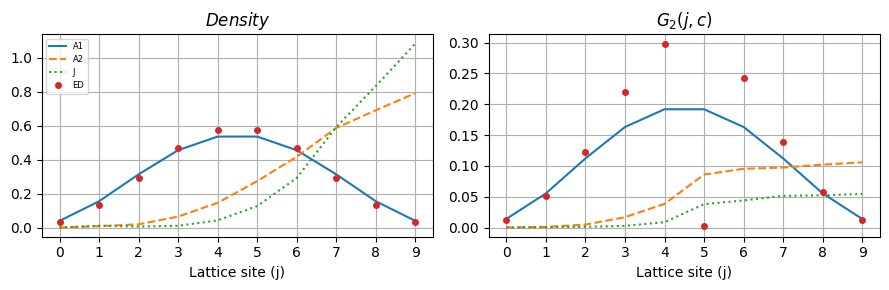

In [91]:
N1i, N2i, NJi, NiRef = getNis(c1), getNis(c2), getNis(cJ),getNis(GS)
nodeForG2 = int(Ns/2)
G12s,G22s, GJ2s, G2sRef = getG2sX(c1,int(Ns/2)),getG2sX(c2,int(Ns/2)), getG2sX(cJ,int(Ns/2)), getG2sX(GS,int(Ns/2))

fig, ax = plt.subplots(1,2,figsize=[9,3])
ax[0].plot(real(N1i),label="A1")
ax[0].plot(N2i,'--',label="A2")
ax[0].plot(NJi,linestyle='dotted',label="J")
#ax[0].plot(N2Ji,'--',label="J")
ax[0].plot(NiRef,'o',label="ED",markersize=4)
# ax[0].plot(N1i,label="$A1, (E1-E_{free})/N=$"+str(round((EAnsatz1-Efree[0])/N,4)))
# ax[0].plot(N2i,'--',label="$A2, (E2-E_{free})/N=$"+str(round((EAnsatz2-Efree[0])/N,4)))
# ax[0].plot(NiRef,'o',label="$ED, (ER-E_{free})/N=$"+str(round((E[0]-Efree[0])/N,4)))
ax[1].plot(G12s,label="A1")
ax[1].plot(G22s,'--',label="A2")
ax[1].plot(GJ2s,linestyle='dotted',label="J")
ax[1].plot(G2sRef,'o',label="ED",markersize=4)

ax[0].grid()
ax[1].grid()

ax[0].set_xlabel("Lattice site (j)")
ax[1].set_xlabel("Lattice site (j)")
ax[0].set_title("$Density$")
ax[1].set_title("$G_1(j,c)$")
ax[1].set_title("$G_2(j,c)$")
ax[0].legend(fontsize=6)

ax[0].set_xticks(range(0,Ns,1))
ax[1].set_xticks(range(0,Ns,1))
#ax[].set_xticks(range(0,Ns[N],1))
plt.tight_layout()
plt.savefig(("1_Ns%i_N%i_J%f_U%f_V%f.png"%(Ns,N,J,U,V)))
#plt.savefig("tmpU"+str(U)+"V"+str(V)+".png")
plt.show()

In [48]:
from sympy.utilities.iterables import multiset_permutations
from operator import itemgetter
from numpy import outer, sort, concatenate
from numpy.linalg import svd
from math import factorial
from itertools import permutations
from time import sleep


u, λ, v =svd(real(phiA2**2), full_matrices=True)

λ*=-1
λ[0]*=-1

print(λ)

[ 0.11965284 -0.03519835 -0.02881322 -0.02236499 -0.0162642  -0.00999473
 -0.00658357 -0.00334064 -0.00168069 -0.00132351]


#### Density profile and G2 correlations


In [93]:
NCombs = []
for i in range(0,N):
    for j in range(i+1,N):
        NCombs.append([i,j])

def Λ(ls):
    out = 1
    for l in ls:
        out *= λ[l]
    return out

def f(l,num):
    out = []
    for i in range(len(NCombs)):
        if num in NCombs[i]:
            out.append(l[i])
    return array(out)

def B(fl):
    out = 1
    for k in range(0,N-1):
        out *= u[:,fl[k]]
    return out

def Γ(fl):
    return sum(B(fl))

factorialNCombs = factorial(len(NCombs))


def gen_N_G2(l):    
    outN = zeros(Ns,dtype=float)
    outG2 = zeros((Ns,Ns),dtype=float)
    for σl in multiset_permutations(l): 
        multip = 1    
        for i in range(2,N):
            multip *= Γ(f(σl,i))
            
        outN += B(f(σl,0))*Γ(f(σl,1)) * multip
        outG2 += outer( array(B(f(σl,0))) , array(B(f(σl,1))) ) * multip
    return factorialNCombs*Λ(l)*outN, factorialNCombs*Λ(l)*outG2


In [94]:
def keyToLs(key):
    out = [0]*len(NCombs)
    for i in range(0,len(NCombs)):
        out[len(NCombs)-1-i]=key%Ns
        key //= Ns
    return out

def lsToKey(ls):
    key = ls[0]
    for i in range(1,len(ls)):
        key*=Ns
        key+=ls[i]
    return key


ls = [0]*len(NCombs)
lss = {}

def numPerms(ls):
    out = 0
    for perm in multiset_permutations(ls):
        out+=1   
    return out

def numPermsB(ls):
    out = 1
    Na = 1
    slots = len(ls)
    lold = ls[0]
    for l in ls[1:]:
        if l != lold:
            out *= factorial(slots)/factorial(slots-Na)/factorial(Na)
            slots -= Na
            Na=1
            lold = l
        else:
            Na+=1
    return out

def appendL(i):
    if i == len(NCombs):
        key = lsToKey(ls)
        lss[key] = numPermsB(ls)*Λ(ls)
    else:
        for j in range(ls[i-1],Ns):
            ls[i]=j
            appendL(i+1)
            
print("Computing vaulues of combinations...",end='')
t0 = time.time()

for i0 in range(0,Ns):
    ls[0]=i0
    appendL(1)
print(" DONE in ",(time.time()-t0)*1000,"[ms]")        


lss = dict(sorted(lss.items(), key=lambda item: abs(item[1]),reverse=True))
keys = list(lss.keys())
coefs = list(lss.values())

Computing vaulues of combinations... DONE in  78.38916778564453 [ms]


In [28]:
print(coefs[0:20])
print(coefs[30000:30020])
print(len(keys))  

[3.3489797668038364e-07, -2.1801624724114322e-07, -2.162611585006983e-07, -2.162611323393756e-07, -2.1083445752517915e-07, -2.108344440457163e-07, -2.0064392778594777e-07, -2.006438983042428e-07, -1.793518365548283e-07, -1.7935181255300005e-07, 1.1732042164924088e-07, 1.1732040745687537e-07, 1.163759469923109e-07, 1.1437646790818945e-07, 1.1437646059565918e-07, 1.1345570693951039e-07, 1.1345569968584794e-07, 1.134556932146632e-07, 1.1345568596100163e-07, 1.1060872448035163e-07]
[]
12376


Computing N and G2.. DONE in  332.6406478881836 [ms]


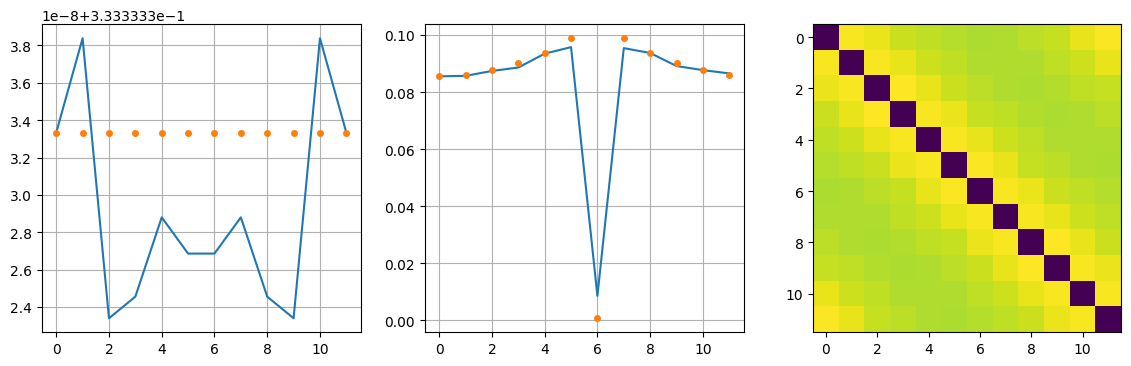

In [29]:
print("Computing N and G2..",end='')
t0 = time.time()


n,G2 = gen_N_G2(keyToLs(keys[0]))
for i in range(1,200):
    [nup,G2up] = gen_N_G2(keyToLs(keys[i]))
    n+=nup
    G2+=G2up
    
print(" DONE in ",(time.time()-t0)*1000,"[ms]")

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(real(n)*NiRef[0]/real(n[0]),'-')
ax[0].plot(NiRef,'o',label="ED",markersize=4)
ax[1].plot([G2[i,int(Ns/2)]*G2sRef[0]/G2[0,int(Ns/2)] for i in range(Ns)],'-',label="math")
ax[1].plot(G2sRef,'o',label="ED",markersize=4)
ax[2].imshow(G2)

ax[0].grid()
ax[1].grid()
plt.show()